# Probabilistic Modeling 

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorchiefs/dlwbl_eth25/blob/master/notebooks/01_hello_prob_dl.ipynb)

### Learning Objectives
In this notebook, we will learn about the basics of probabilistic modeling. 

### Generation of some  data

In [1]:
import numpy as np
np.random.seed(42)
N = 1000 # number of data points
x_train = np.random.uniform(-1, 1, (N, 1)).astype(np.float32)
y_train = (2 * x_train + 0.1*np.random.normal(0, 10 * np.abs(x_train) + 1, (N, 1))).astype(np.float32)
#plt.scatter(x_train, y_train, color="black", label="Training data")

In [2]:
import os
# Set Keras backend to PyTorch
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1" #Needed on MAC to avoid MPS error (22 Nov 2024)
os.environ["KERAS_BACKEND"] = "torch" # Before importing Keras!

import numpy as np
from keras import layers, Input, Model
from keras.optimizers import Adam
import torch
from torch.distributions import Normal
import matplotlib.pyplot as plt
import time


# Print versions
import keras
print(f"Keras version: {keras.__version__}")
print(f"Backend: {keras.backend.backend()}")
print(f"torch version: {torch.__version__}")

Keras version: 3.8.0
Backend: torch
torch version: 2.5.1


Currently there is no `DistributionLayer` in Keras 3.0, as there is in tf_keras (see [pm_tfkeras.ipynb](https://github.com/tensorchiefs/dl_keras3/blob/main/notebooks/probabilistic_modelling/pm_tfkeras.ipynb)). Therefore we create a wrapper object that takes the output of the NN and returns a numpyro distribution object.  

### 1. Define a model with as many outputs as the number of parameters of the distribution

Here we use as outcome distribution a Gaussian so we need two outputs.

In [3]:
# Define the model
inputs = Input(shape=(1,))
hidden = layers.Dense(10, activation="relu")(inputs)
# ... more hidden layers ...
outputs = layers.Dense(2)(hidden)  # <--- Outputs mean and log(sd)
model = Model(inputs=inputs, outputs=outputs)

### 2. Link the outputs of the model to the parameters of the distribution

In [4]:
# Wrapper function to convert model output to a PyTorch Normal distribution
@staticmethod
def output_to_gaussian_distribution(output):
    mean = output[:, 0:1]   # Gets the first column while keeping dimensions (like output[, 1, drop=FALSE] in R)  
    log_sd = output[:, 1:2] # Gets the second column while keeping dimensions
    scale = torch.exp(log_sd) # Inverse link function to ensure positive scale
    return Normal(loc=mean, scale=scale)

### 3. Define NLL


In [5]:
# Custom Negative Log-Likelihood Loss
def negative_log_likelihood(y_true, output):
    dist = output_to_gaussian_distribution(output)
    return -dist.log_prob(torch.tensor(y_true)).mean()

# Compile the model
model.compile(optimizer="adam", loss=negative_log_likelihood)

### Training

In [6]:
print(F'Prediction on untrained model (5 Datapoints)\n {model.predict(x_train[0:5])}')

# Train the model and measure timing
epochs = 100
start_time = time.time()
hist = model.fit(x_train, y_train, epochs=epochs, batch_size=32, verbose=0)
torch_training_time = time.time() - start_time

print(f"Torch Training Time: {torch_training_time:.2f} seconds")

# Predict the distribution
x_test = np.linspace(-1, 1, epochs).reshape(-1, 1)
dist = output_to_gaussian_distribution(model(x_test))

# Use the distribution
samples = dist.sample((5,))  # Draw 5 samples
print("Torch Samples:", samples.shape)

log_p = dist.log_prob(torch.tensor(0.1)).cpu().detach().numpy()
log_p.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step
Prediction on untrained model (5 Datapoints)
 [[ 0.13223296 -0.05449912]
 [-0.5513498   0.47508174]
 [-0.28379357  0.24453646]
 [-0.12068696  0.10399237]
 [ 0.36255157 -0.14942372]]


/var/folders/bk/0vv7sh9n43n3dm4fth1qw93r0000gq/T/ipykernel_10677/170564135.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return -dist.log_prob(torch.tensor(y_true)).mean()


Torch Training Time: 24.12 seconds
Torch Samples: torch.Size([5, 100, 1])


(100, 1)

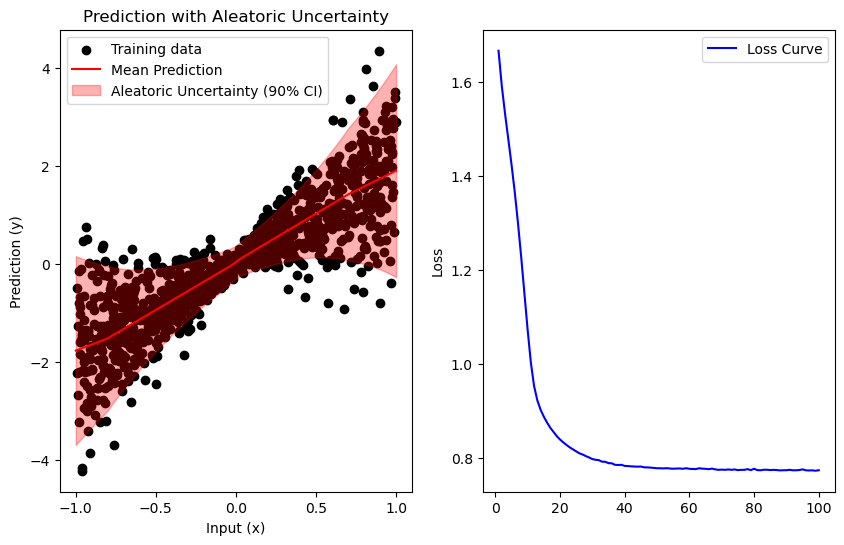

In [15]:
# Compute 5% and 95% quantiles directly
quantile_5 = dist.icdf(torch.tensor(0.05)).cpu().detach().numpy()
quantile_95 = dist.icdf(torch.tensor(0.95)).cpu().detach().numpy()
mean = dist.mean.cpu().detach().numpy().squeeze()

# Extract loss values from the training history
loss_values = hist.history['loss']
epochs = range(1, len(loss_values) + 1)

# Visualisierung
import matplotlib.pyplot as plt
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))


# Plot the prediction with uncertainty
ax1.scatter(x_train, y_train, color="black", label="Training data")
ax1.plot(x_test, mean, color="red", label="Mean Prediction")
ax1.fill_between(
    x_test.ravel(),
    quantile_5.squeeze(),  # 5%-Quantil
    quantile_95.squeeze(),  # 95%-Quantil
    color="red",
    alpha=0.3,
    label="Aleatoric Uncertainty (90% CI)"
)
ax1.set_xlabel("Input (x)")
ax1.set_ylabel("Prediction (y)")
ax1.legend(loc="upper left")
ax1.set_title("Prediction with Aleatoric Uncertainty")

# Create a secondary y-axis for the loss curve
ax2.plot(epochs, loss_values, color="blue", label="Loss Curve")
ax2.set_ylabel("Loss")
ax2.legend(loc="upper right")

plt.show()

### 